In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import color
from skimage.filters import gaussian
from skimage.transform import resize, ProjectiveTransform, warp
from harris import get_harris_corners

Part B.1: Harris Corner Detection

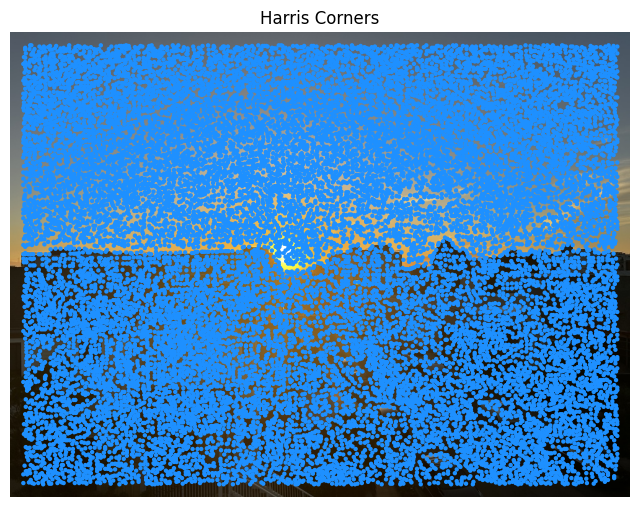

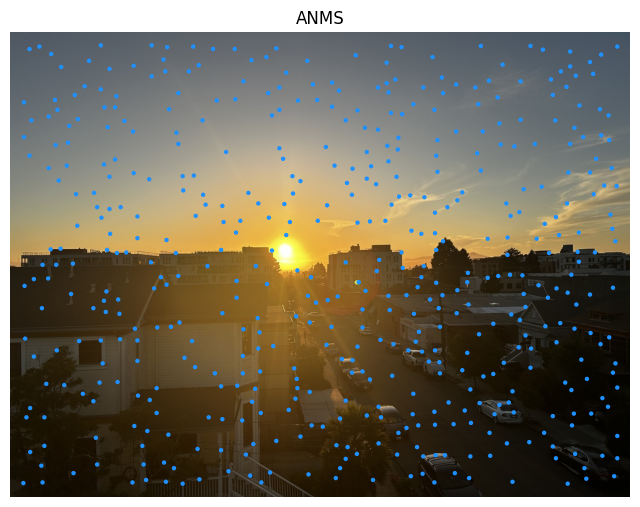

In [8]:
image_path = Path('images/B1.jpg')
im = plt.imread(image_path)

h, (y, x) = get_harris_corners(color.rgb2gray(im))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.scatter(x, y, s=10, c='dodgerblue', edgecolor='none')
ax.set_title('Harris Corners')
ax.axis('off')
plt.show()

def anms(coords, res):
    points = np.column_stack((coords[1], coords[0]))
    radii = np.empty(points.shape[0])
    radii[:] = np.inf
    for i in range(points.shape[0]):
        mask = res > res[i] * 0.9
        mask[i] = False
        if np.any(mask):
            dists = (points[mask, 0] - points[i, 0]) ** 2 + (points[mask, 1] - points[i, 1]) ** 2
            radii[i] = np.min(dists)
    order = np.argsort(-radii)
    return points[order[:500]]

pts = anms((y, x), h[y, x])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.scatter(pts[:, 0], pts[:, 1], s=10, c='dodgerblue', edgecolor='none')
ax.set_title('ANMS')
ax.axis('off')
plt.show()


B.2: Feature Descriptor Extraction

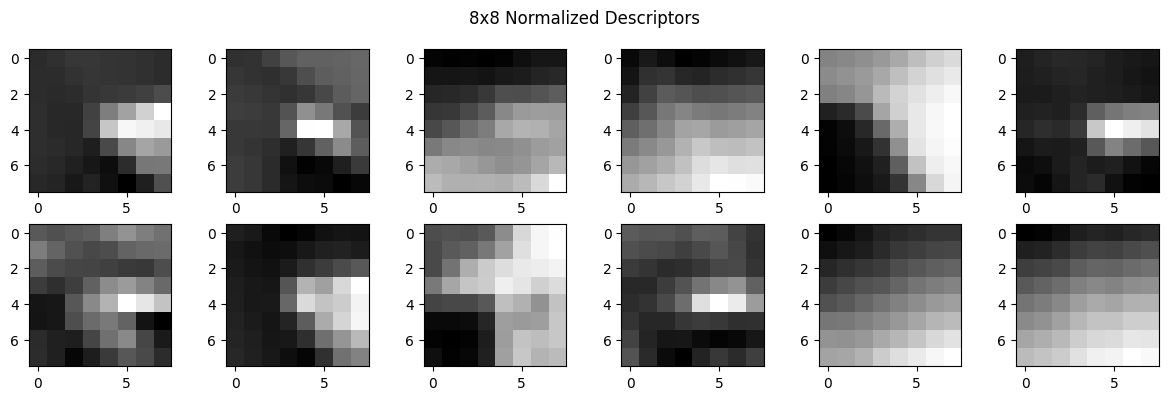

In [9]:
def features(im):
    image = plt.imread(im)
    gray = color.rgb2gray(image)
    h, (ys, xs) = get_harris_corners(gray)
    pts = anms((ys, xs), h[ys, xs])
    descriptors = [] 
    for x, y in pts[:500]:
        window = gray[y-20:y+20, x-20:x+20]
        patch = resize(gaussian(window, sigma=2), (8, 8), anti_aliasing=True)
        patch = patch - patch.mean()
        norm = np.linalg.norm(patch)
        if norm < 1e-12:
            continue
        descriptors.append(patch.ravel())
    return [[i, j] for i, j in pts[:500]], np.array(descriptors), image
_, fa, _ = features(image_path)
i = 0
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for r in range(axes.shape[0]):
    for c in range(axes.shape[1]):
        if i >= len(fa):
            break
        axes[r, c].imshow(fa[i].reshape(8, 8), cmap='gray')
        i += 1

fig.suptitle('8x8 Normalized Descriptors')
plt.tight_layout()
plt.show()

B.3: Feature Matching

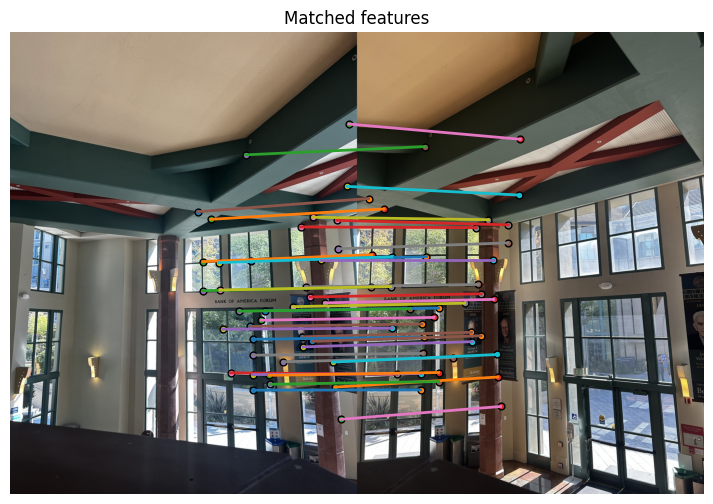

In [33]:
def matcher(desc1, desc2):
    dists = np.linalg.norm(desc1[:, None, :] - desc2[None, :, :], axis=2)
    idx = np.argsort(dists, axis=1)
    a = idx[:, 0]
    b = idx[:, 1]
    ratios = np.take_along_axis(dists, a[:, None], axis=1) / (np.take_along_axis(dists, b[:, None], axis=1))
    matches = []
    for i in range(len(ratios)):
        if ratios[i] < 0.5:
            matches.append((i, a[i], ratios[i]))
    return matches

ka, da, ima = features(Path('images/B3.1_.jpg'))
kb, db, imb = features(Path('images/B3.2_.jpg'))

ima = np.clip(ima / 255.0, 0.0, 1.0)
imb = np.clip(imb / 255.0, 0.0, 1.0)

matches = matcher(da, db)

fig, ax = plt.subplots(figsize=(12, 6))
combined = np.concatenate((ima, imb), axis=1)
ax.imshow(combined)
ax.axis('off')

offset = ima.shape[1]
to_show = matches[:100]
for m in to_show:
    a, b, _ = m
    x1, y1 = ka[a]
    x2, y2 = kb[b]
    ax.plot([x1, x2 + offset], [y1, y2], lw=2, alpha=1.0)
    ax.scatter([x1], [y1], s=24, marker='o', edgecolors='k')
    ax.scatter([x2 + offset], [y2], s=24, marker='o', edgecolors='k')
ax.set_title("Matched features")
plt.show()


B.4: RANSAC for Robust Homography

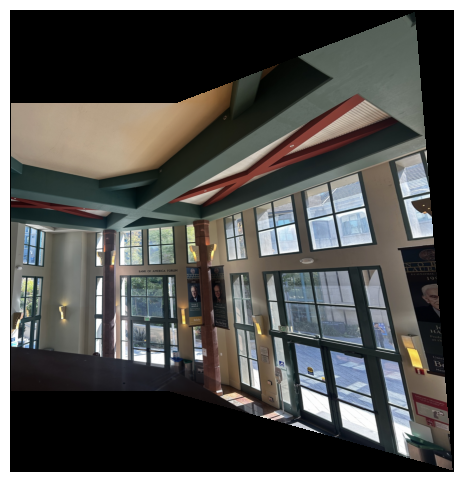

In [34]:
import helper_same_as_3a as helpers

def ransac(src_pts, dst_pts):
    best = None
    for _ in range(2000):
        H = helpers.computeH(src_pts, dst_pts)
        check = np.linalg.norm(helpers.helper(src_pts, H) - dst_pts, axis=1) < 5.0
        if best is None or check.sum() > best.sum():
            best = check
    return best

match_pairs = np.array([(i, j) for i, j, _ in matches], dtype=int)
pts_a = np.array(ka)[match_pairs[:, 0]]
pts_b = np.array(kb)[match_pairs[:, 1]]

res = ransac(pts_a, pts_b)
H = helpers.computeH(pts_b[res], pts_a[res])

mosaic = helpers.mosaic(ima * 255.0, imb * 255.0, H)
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(np.clip(mosaic, 0.0, 1.0))
ax.axis('off')
plt.show()
